<h1>Построение модели предсказания коэффициента восстановления золота из золотосодержащей руды</h1>

Необходимо подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Как золото получают из руды? 

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку. После флотации получается, так называемый, черновой концентрат, а после двухэтапной очистки - финальный концентрат.  

**Описание данных**

Признаки имеют вид: [этап].[тип_параметра].[название_параметра], где возможные значения для блока [этап]: 

    rougher — флотация
    primary_cleaner — первичная очистка
    secondary_cleaner — вторичная очистка
    final — финальные характеристики

Возможные значения для блока [тип_параметра]:

    input — параметры сырья
    output — параметры продукта
    state — параметры, характеризующие текущее состояние этапа
    calculation — расчётные характеристики

Эффективность обогащения - т.н. recovery - зависит от доли золота в концентрате после флотации/очистки; доли золота в сырье/концентрате до флотации/очистки; доли золота в отвальных хвостах после флотации/очистки. 

Метрика качества в задаче - sMAPE. 

Данные для исследования в трех файлах:

    gold_recovery_train.csv — обучающая выборка 
    gold_recovery_test.csv — тестовая выборка 
    gold_recovery_full.csv — исходные данные

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

**План работы**: первым делом мы познакомимся с данными, проведем предобработку и исследовательский анализ, затем - построим модель предсказания и оценим ее качество.

<h3>Оглавление</h3>

1. [Шаг 1: Подготовка данных](#start)
2. [Шаг 2: Исследовательский анализ данных](#research)
3. [Шаг 3: Построение и обучение модели](#model)

<h3> Шаг 1: Подготовка данных </h3>
<a id='start'></a>

Извлечем необходимые нам библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
import copy
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

Познакомимся с данными в файлах.

In [2]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
train = pd.read_csv('/datasets/gold_recovery_train.csv')

In [3]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Как и ожидалось, количество столбцов в датафрейме с тестовой выборкой меньше. Также заметно наличие пропусков во всех таблицах.

Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. 

Так как мы считаем эффективность обогащения после флотации, нам потребуются следующие переменные: доля золота в концентрате после флотации - rougher.output.concentrate_au, доля золота в сырье до флотации - rougher.input.feed_au, доля золота в отвальных хвостах после флотации - rougher.output.tail_au . 

Как известно, в нашей таблице есть пропуски и они могут помешать нам провести данную процедуру. Создадим новый - временный - датафрейм, в котором удалим все строки с пропущенными значениями в данных столбцах.

In [6]:
train_current = train.drop(train[(train['rougher.input.feed_au'].isna()) | (train['rougher.output.recovery'].isna(
)) | (train['rougher.output.tail_au'].isna()) | (train['rougher.output.concentrate_au'].isna(
))].index)

In [7]:
recovery_testing = ( train_current['rougher.output.concentrate_au']* (
    train_current['rougher.input.feed_au'] - train_current['rougher.output.tail_au'])) / (
    train_current['rougher.input.feed_au'] * (train_current['rougher.output.concentrate_au'] - train_current['rougher.output.tail_au'] )) * 100

Найдем MAE между нашими расчётами и значением признака.

In [8]:
mean_absolute_error(train_current['rougher.output.recovery'], recovery_testing)

9.444891926100695e-15

Получили значение практически равное 0, значит, эффективность обогащения рассчитана правильно.

Проанализируем параметры, которые недоступны в тестовой выборке. Для начала получим их список.

In [9]:
output_set = set(train.columns).difference(set(test.columns))
output_set

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Итак, закономерность на лицо. В тестовой выборке отсутствуют параметры типа output - то, что получается УЖЕ в процессе работы с рудой. Различные содержания веществ в выходных продуктах этапов, а также рассчеты связанные с содержанием золота в продуктах. Такие обстоятельства вполне логичны. Поскольку предполагается, что мы предсказываем заранее, пока процесс еще начался. Сделаем важный вывод отсюда - столбцы, что отсутствуют в тестовой выборке, нельзя использовать при обучении модели.

Проведем предобработку данных. Нам следует разобраться с пропусками. В этом деле мы воспользуемся фактом того, что соседние по времени параметры похожи.  Проверим это.

In [10]:
train.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


Действительно, значения отличаются не сильно. 

Напишем функцию и заменим там, где возможно, пропущенные значения средним арифметическим их соседей - и в тренировочной, и в тестовой выборке. Если значение не удалось заменить, значит, рядом с ним нет непустых ячеек, поэтому - восстановить их невозможно.

Также напишем функцию, которая выводит количество NaNов в столбце с наибольшим их содержанием, а также отношение этого значения к размеру датафрейма. Потребуется для оценки результатов и принятия решения об удалении строк с пропущенными значениями.

In [11]:
def filler(data, column):
    current = copy.deepcopy(data[column]) #столбец
    indexes = data[current.isna()].index #индексы пропусков в столбце
    FIRST_INDEX = 0
    SECOND_INDEX = 1
    last_index = len(data) - 1
    for i in indexes:
        if i == FIRST_INDEX or i == SECOND_INDEX:
            fill_slice = current.loc[i+1:i+2]
        elif i == last_index: 
            fill_slice = current.loc[i-2:i-1]
        else:
            fill_slice = pd.concat([pd.Series(current.loc[i-2:i-1]), pd.Series(current.loc[i+1:i+2])])
        if fill_slice.isna().sum() == len(fill_slice):
            data.loc[i, column] = np.nan
        else:
            data.loc[i, column] = fill_slice.mean()

In [12]:
def nan_check(data):
    summ = data.isna().sum().max()
    print('Наибольшее количество NaN: {}'.format(summ))
    print('Это {:.2} от размера датафрейма'.format(summ/data.shape[0]))

In [13]:
nan_check(train)
nan_check(test)

Наибольшее количество NaN: 2573
Это 0.15 от размера датафрейма
Наибольшее количество NaN: 353
Это 0.06 от размера датафрейма


In [14]:
columns_train = list(train.columns)

In [15]:
for j in columns_train: 
    filler(train, j)

In [16]:
columns_test = list(test.columns)

In [17]:
for j in columns_test:
    filler(test, j)

Посмотрим на результаты. 

In [18]:
nan_check(train)
nan_check(test)

Наибольшее количество NaN: 1880
Это 0.11 от размера датафрейма
Наибольшее количество NaN: 254
Это 0.043 от размера датафрейма


Заменить удалось не все. Итак, мы заменяли пропуски на основании значений, содержащихся в соседних ячейках. Если мы не заменили что-то, значит, что в рядом лежащих ячейках тоже были NaNы. Что делать с оставшимися пропусками? Рассмотрим варианты. Во-первых, можно заменить, но тогда вопрос - чем? В данной ситуации брать среднее значение по столбцу или медиану было бы некорректно, так как значения параметров меняются от процесса к процессу и могут сильно отличаться, соседями мы уже воспользовались. Источников информации больше нет. Во-вторых, можно удалить, но это слишком много строк. Сделаем так: из тестововой выборки все строки с пропущенными значениями; из тренировочной выборки удалим те строки, в которых пропуски в столбцах, необходимых для обучения модели - мы не можем оставить их как есть по понятным причинам.

In [19]:
def deleting(data, columns):
    print('Количество строк до удаления: {}'.format(data.shape[0]))
    new = data.dropna(subset=columns)
    print('Количество строк  после удаления: {}'.format(new.shape[0]))
    return new

In [20]:
test = deleting(test, columns_test)

Количество строк до удаления: 5856
Количество строк  после удаления: 5557


In [21]:
columns_test.append('final.output.recovery')
columns_test.append('rougher.output.recovery')

In [22]:
train = deleting(train, columns_test)

Количество строк до удаления: 16860
Количество строк  после удаления: 13649


Готово.

**Вывод по Шагу 1**: итак, на данном шаге мы ознакомились с данными, узнали отличие тестового набора от обучающего, что дало ключ к ответу на вопрос - какие признаки можно использовать при создании набора, также проверили правильность рассчета эффективности обогащения в таблице и удалили строки с пропущенными значениями, а там где получилось - часть из них заменили.

<h3> Шаг 2: Исследовательский анализ данных</h3>
<a id='research'></a>

На данном Шаге предстоит изучить некоторые закономерности в выборке и сделать выводы. 

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Для этого воспользуемся выборкой, которая является объединением и тестовой, и тренировочной, она больше - результаты будут точнее. 

Как известно, у нас два этапа очистки - первый и второй. Столбцы, содержащие концентрацию веществ: 

    - концентрация Au до первой очистки: 'rougher.output.concentrate_au', концентрация Au до второй (после первой) отчистки: 'primary_cleaner.output.concentrate_au', концентрация Au после второй очистки: 'final.output.concentrate_au'
    - подобные названия и для Ag, и для Pb

In [23]:
def conc(met):
    before1 = 'rougher.input.feed_' + met
    before2 = 'rougher.output.concentrate_' + met
    after1 = 'primary_cleaner.output.concentrate_' + met
    after2 = 'final.output.concentrate_' + met
    new_data = pd.DataFrame()
    new_name1 = 'Концентрация ' + met + ' в сырье'
    new_name2 = 'Концентрация ' + met + ' после флотации'
    new_name3 = 'Концентрация ' + met + ' после первой очистки'
    new_name4 = 'Концентрация ' + met + ' после второй очистки'
    new_data[new_name1] = full[before1]
    new_data[new_name2] = full[before2]
    new_data[new_name3] = full[after1]
    new_data[new_name4] = full[after2]
    new_data.plot(kind='hist', bins=50, grid=True, alpha=0.5)
    plt.xlabel('Концентрация')
    plt.ylabel('Частота')
    plt.title('Распределение концентрации ' + met + ' по этапам')
    plt.show()

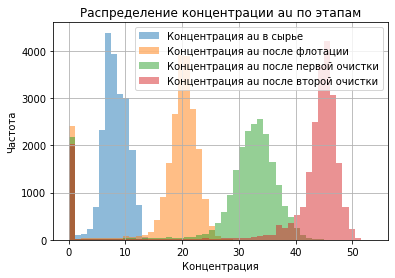

In [24]:
conc('au')

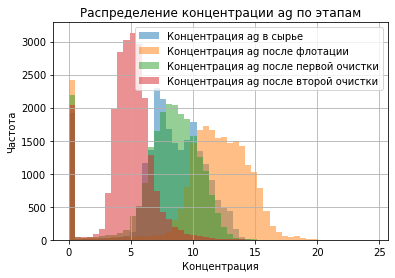

In [25]:
conc('ag')

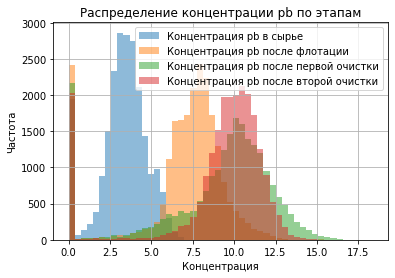

In [26]:
conc('pb')

Какие можно сделать выводы по увиденным графикам? 

    - концентрация Au - золота становится больше после каждого этапов, что вполне логично и соответствует смыслу процедуры в целом;
    - концентрация Ag - серебра падает, а концентрация Pb - свинца растет;

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

Размер гранул у нас в столбце -  'rougher.input.feed_size'. Построим гистаграммы для обеих выборок. Построим по две гистограммы на выборку.

In [27]:
def feed_size(data):
    if data.shape[0] <10000:
        name = 'тестовой выборке'
    else:
        name = 'тренировочной выборке'
    data['rougher.input.feed_size'].plot(kind='hist', bins=50, grid=True, density=True)
    plt.xlabel('Размер гранул')
    plt.ylabel('Частота')
    plt.title('Распределение размеров гранул сырья в ' + name)
    plt.show()
    data['rougher.input.feed_size'].plot(kind='hist', bins=30, grid=True, density=True, range=(0,150))
    plt.xlabel('Размер гранул')
    plt.ylabel('Частота')
    plt.title('Распределение размеров гранул сырья в ' + name + ' в диапазоне от 0 до 150')
    plt.show()

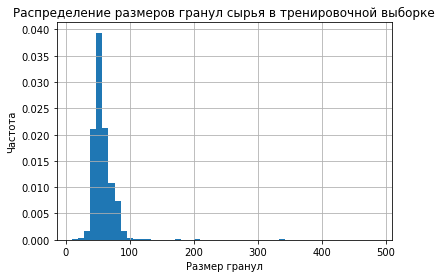

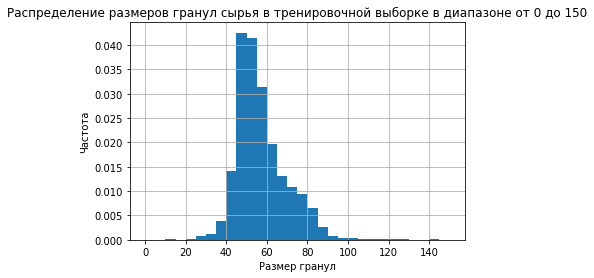

In [28]:
feed_size(train)

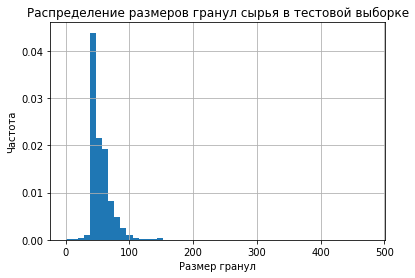

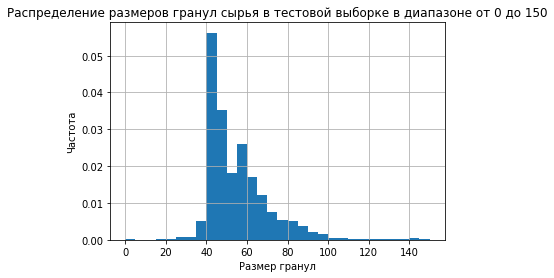

In [29]:
feed_size(test)

Какие выводы можно сделать из полученных графиков? Распределения в двух выборках весьма похожи, единственное - наиболее часто встречающиеся значения в тестовой выборке сдвинуты влево относительно тренировочной. В целом, различия не существенные, и оценка модели должна быть корректной.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах на предмет аномалий. Под веществами будем понимать Au (золото), Ag (серебро) и Pb (свинец). Концентрации в сырье хранятся в столбцах: 'rougher.input.feed_pb', 'rougher.input.feed_au', 'rougher.input.feed_ag', концентрации в черновом концентрате в: 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', концентрации в финальном концентрате: 'final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb'.

Суммарную концентрацию будем смотреть и в тренировочной, и в тестовой выборке. Начнем с тренировочной.

In [30]:
feed_columns = [ 'rougher.input.feed_pb', 'rougher.input.feed_au', 'rougher.input.feed_ag']
black_columns = [ 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']
final_columns = ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb']
def summ_conc(c, name, data):
    summary = data[c[0]] + data[c[1]] + data[c[2]]
    summary.plot(kind='hist', bins=50, grid=True, density=True)
    plt.xlabel('Суммарная концентрация веществ в ' + name)
    plt.ylabel('Частота')
    plt.title('Распределение суммарной концентрации веществ в ' + name)
    plt.show()

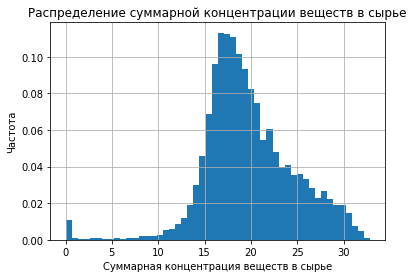

In [31]:
summ_conc(feed_columns, 'сырье', train)

Какие выводы можно сделать по увиденному? Пик у нуля явно не вписывается в общую картину. С высокой вероятностью, это выбросы. Удалим их перепостроим график. 

In [32]:
def drop_anom(data, c):
    return data.drop(data[(data[c[0]] + data[c[1]] + data[c[2]]) < 1].index)

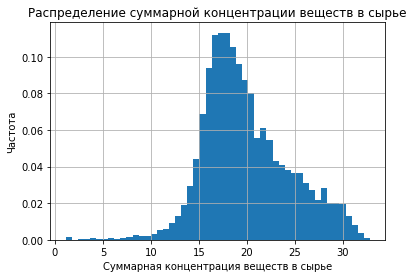

In [33]:
train = drop_anom(train, feed_columns)
summ_conc(feed_columns, 'сырье', train)

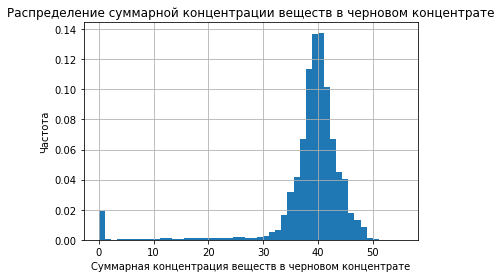

In [34]:
summ_conc(black_columns, 'черновом концентрате', train)

Ситуация аналогична ситуации с сырьем - удалим выбросы.

In [35]:
train = drop_anom(train, black_columns)

И, наконец, финальный концентрат.

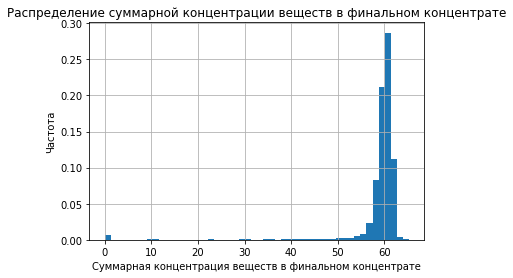

In [36]:
summ_conc(final_columns, 'финальном концентрате', train)

В связи с удалением на предыдущих этапах, здесь сомнительных значений осталось немного. Но и их удалим.

In [37]:
train = drop_anom(train, final_columns)

Теперь то же самое для тестовой выборки - а точнее, только для сырья. Поскольку в тестовой выборке нет столбцов типа output.

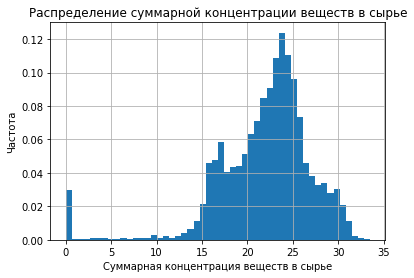

In [38]:
summ_conc(feed_columns, 'сырье', test)

In [39]:
test = drop_anom(test, feed_columns)

Итак, мы удалили выбросы в тестовой и в тренировочной выборке.  

**Вывод по Шагу 2**: итак, на данном Шаге мы провели исследовательский анализ - рассмотрели закономерности в некоторых величинах, а именно: посмотрели, как меняется концентрация некоторых металлов от этапа к этапу, как распределены размеры гранул сырья в тестовой и обучающей выборках, как распределены суммарные концентрации металлов на различных этапах. Последний пункт нашей работы позволил нам избавиться от выбросов. 

<h3> Шаг 3: Построение и обучение модели </h3>
<a id='model'></a>

На данном Шаге нам следует обучить несколько моделей и проверить их качество кросс-валидацией, затем выбрать из них лучшую и проверить ее качество на тестовой выборке.

Вспомним, что в данной работе мы оцениваем качество с помощью итоговой sMAPE. Напишем функцию для ее вычисления. 

In [40]:
def smape(true, predicted):
    smape = (abs(true - predicted) / ((abs(true) + abs(predicted)) / 2)).sum() / len(true) * 100
    return smape
def smape_final(rougher, predicted_rougher, final, predicted_final):
    final_smape = 0.25 * smape(rougher, predicted_rougher) + 0.75 * smape(final, predicted_final)
    return final_smape

Также - отделим целевые признаки - эффективность обогащения черного концентрата и эффективность обогащения финального концентрата. Помимо этого - избавимся от столбца с датой и других ненужных признаков.

In [41]:
target1 = train['rougher.output.recovery']
target2 = train['final.output.recovery']
output_set = list(output_set)
output_set.append('date')
features = train.drop(columns=output_set)

Удалим часть признаков, так как - многие сильно коррелируют между собой. Произведем поиск таких признаков.

In [42]:
def comparing_corr(corr_table, columns, x, y):
    corr_dict = {i:0 for i in columns[x:y]}
    for i in columns[x:y]:
        for j in columns: 
            if corr_table[i][j] >= 0.8 and i != j:
                print(i + ' + ' + j + ' : ' + str(corr_table[i][j]))
                if j in corr_dict and i in corr_dict:
                    corr_dict[i] +=1
                    corr_dict[j] = 0
                else:
                    corr_dict[i] += 1
    print(' ')
    for i in corr_dict:
        print(i, ':', corr_dict[i])

Сравним первые 10 признаков со всеми признаками.

In [43]:
corr_table = features.corr()
comparing_corr(corr_table, features.columns, 0, 10)

primary_cleaner.state.floatbank8_a_air + primary_cleaner.state.floatbank8_b_air : 0.9460492575729288
primary_cleaner.state.floatbank8_a_air + primary_cleaner.state.floatbank8_c_air : 0.9361575152693311
primary_cleaner.state.floatbank8_a_level + primary_cleaner.state.floatbank8_b_level : 0.9753401112812948
primary_cleaner.state.floatbank8_a_level + primary_cleaner.state.floatbank8_c_level : 0.959906043725259
primary_cleaner.state.floatbank8_b_air + primary_cleaner.state.floatbank8_a_air : 0.9460492575729288
primary_cleaner.state.floatbank8_b_air + primary_cleaner.state.floatbank8_c_air : 0.9428874909767538
primary_cleaner.state.floatbank8_b_level + primary_cleaner.state.floatbank8_a_level : 0.9753401112812948
primary_cleaner.state.floatbank8_b_level + primary_cleaner.state.floatbank8_c_level : 0.9657223956710465
primary_cleaner.state.floatbank8_c_air + primary_cleaner.state.floatbank8_a_air : 0.9361575152693311
primary_cleaner.state.floatbank8_c_air + primary_cleaner.state.floatbank8_b_

Итак, у нас primary_cleaner.state.floatbank8_a_air сильно коррелирует с primary_cleaner.state.floatbank8_b_air, primary_cleaner.state.floatbank8_c_air, мы можем удалить оба этих признака - вместо них останется primary_cleaner.state.floatbank8_a_air; также у нас primary_cleaner.state.floatbank8_a_level сильно коррелирует с primary_cleaner.state.floatbank8_b_level и primary_cleaner.state.floatbank8_c_level, их мы удалим.

In [44]:
features = features.drop(
    columns=['primary_cleaner.state.floatbank8_b_air',
             'primary_cleaner.state.floatbank8_c_air', 
            'primary_cleaner.state.floatbank8_b_level',
            'primary_cleaner.state.floatbank8_c_level'])

Теперь проведем такую работу и с остальными столбцами.

In [45]:
comparing_corr(corr_table, features.columns, 6, 16)

rougher.input.feed_ag + rougher.input.feed_au : 0.8503602306476628
rougher.input.feed_au + rougher.input.feed_ag : 0.8503602306476628
rougher.input.floatbank10_sulfate + rougher.input.floatbank11_sulfate : 0.9484429339485528
rougher.input.floatbank10_xanthate + rougher.input.floatbank11_xanthate : 0.9285510923457084
 
primary_cleaner.state.floatbank8_d_air : 0
primary_cleaner.state.floatbank8_d_level : 0
rougher.input.feed_ag : 0
rougher.input.feed_pb : 0
rougher.input.feed_rate : 0
rougher.input.feed_size : 0
rougher.input.feed_sol : 0
rougher.input.feed_au : 1
rougher.input.floatbank10_sulfate : 1
rougher.input.floatbank10_xanthate : 1


In [46]:
features = features.drop(columns=['rougher.input.feed_ag', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate'])

In [47]:
comparing_corr(corr_table, features.columns, 13, 23)

rougher.state.floatbank10_b_air + rougher.state.floatbank10_c_air : 0.9256956282844501
rougher.state.floatbank10_b_air + rougher.state.floatbank10_d_air : 0.9162822508913245
rougher.state.floatbank10_b_air + rougher.state.floatbank10_e_air : 0.8151678607110571
rougher.state.floatbank10_b_air + rougher.state.floatbank10_f_air : 0.8083302869580198
rougher.state.floatbank10_b_level + rougher.state.floatbank10_c_level : 0.981095185039497
rougher.state.floatbank10_b_level + rougher.state.floatbank10_d_level : 0.971992950875034
rougher.state.floatbank10_b_level + rougher.state.floatbank10_e_level : 0.9646740671679873
rougher.state.floatbank10_b_level + rougher.state.floatbank10_f_level : 0.9567381148984764
rougher.state.floatbank10_c_air + rougher.state.floatbank10_b_air : 0.9256956282844501
rougher.state.floatbank10_c_air + rougher.state.floatbank10_d_air : 0.8979092675923218
rougher.state.floatbank10_c_level + rougher.state.floatbank10_b_level : 0.981095185039497
rougher.state.floatbank10_

In [48]:
features = features.drop(columns=['rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air',
                                 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_f_air', 
                                 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_level',
                                 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_level'])
comparing_corr(corr_table, features.columns, 15, 25)

secondary_cleaner.state.floatbank2_a_air + secondary_cleaner.state.floatbank2_b_air : 0.8771894336257499
secondary_cleaner.state.floatbank2_a_level + secondary_cleaner.state.floatbank2_b_level : 0.8993106798551812
secondary_cleaner.state.floatbank2_b_air + secondary_cleaner.state.floatbank2_a_air : 0.8771894336257499
secondary_cleaner.state.floatbank2_b_level + secondary_cleaner.state.floatbank2_a_level : 0.8993106798551812
 
rougher.state.floatbank10_a_air : 0
rougher.state.floatbank10_a_level : 0
rougher.state.floatbank10_b_air : 0
rougher.state.floatbank10_b_level : 0
secondary_cleaner.state.floatbank2_a_air : 0
secondary_cleaner.state.floatbank2_a_level : 0
secondary_cleaner.state.floatbank2_b_air : 1
secondary_cleaner.state.floatbank2_b_level : 1
secondary_cleaner.state.floatbank3_a_air : 0
secondary_cleaner.state.floatbank3_a_level : 0


In [49]:
features = features.drop(columns=['secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank2_b_level'])
comparing_corr(corr_table, features.columns, 23, 33)

secondary_cleaner.state.floatbank4_a_air + secondary_cleaner.state.floatbank4_b_air : 0.8381269573666625
secondary_cleaner.state.floatbank4_b_air + secondary_cleaner.state.floatbank4_a_air : 0.8381269573666625
secondary_cleaner.state.floatbank4_b_air + secondary_cleaner.state.floatbank5_a_air : 0.8083190605660646
secondary_cleaner.state.floatbank4_b_air + secondary_cleaner.state.floatbank5_b_air : 0.8784378284066477
secondary_cleaner.state.floatbank5_a_air + secondary_cleaner.state.floatbank4_b_air : 0.8083190605660646
secondary_cleaner.state.floatbank5_a_air + secondary_cleaner.state.floatbank5_b_air : 0.8868753473284413
secondary_cleaner.state.floatbank5_a_level + secondary_cleaner.state.floatbank5_b_level : 0.8889807108909147
secondary_cleaner.state.floatbank5_b_air + secondary_cleaner.state.floatbank4_b_air : 0.8784378284066477
secondary_cleaner.state.floatbank5_b_air + secondary_cleaner.state.floatbank5_a_air : 0.8868753473284413
secondary_cleaner.state.floatbank5_b_level + second

In [50]:
features = features.drop(columns=['secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank5_a_air',  
                      'secondary_cleaner.state.floatbank5_a_level'])
comparing_corr(corr_table, features.columns, 30, 40)

 
secondary_cleaner.state.floatbank6_a_air : 0
secondary_cleaner.state.floatbank6_a_level : 0


In [51]:
comparing_corr(corr_table, features.columns, 0, 40)

 
primary_cleaner.input.sulfate : 0
primary_cleaner.input.depressant : 0
primary_cleaner.input.feed_size : 0
primary_cleaner.input.xanthate : 0
primary_cleaner.state.floatbank8_a_air : 0
primary_cleaner.state.floatbank8_a_level : 0
primary_cleaner.state.floatbank8_d_air : 0
primary_cleaner.state.floatbank8_d_level : 0
rougher.input.feed_pb : 0
rougher.input.feed_rate : 0
rougher.input.feed_size : 0
rougher.input.feed_sol : 0
rougher.input.feed_au : 0
rougher.input.floatbank11_sulfate : 0
rougher.input.floatbank11_xanthate : 0
rougher.state.floatbank10_a_air : 0
rougher.state.floatbank10_a_level : 0
rougher.state.floatbank10_b_air : 0
rougher.state.floatbank10_b_level : 0
secondary_cleaner.state.floatbank2_a_air : 0
secondary_cleaner.state.floatbank2_a_level : 0
secondary_cleaner.state.floatbank3_a_air : 0
secondary_cleaner.state.floatbank3_a_level : 0
secondary_cleaner.state.floatbank3_b_air : 0
secondary_cleaner.state.floatbank3_b_level : 0
secondary_cleaner.state.floatbank4_a_air : 0

In [52]:
features.shape[1]

32

Итог - получили таблицу с 32 признаками вместо 52, при это ни один из них не коррелирует с другим сильнее, чем с коэффициентом Пирсона 0.8

Напишем функцию для осуществления кросс-валидации, где в качестве метрики качества будет использоваться итоговое sMAPE.

In [53]:
def cross_validation(model1, model2, features, target1, target2):
    results = []
    for i in range(5):
        fold_size = features.shape[0] / 5
        i = i*fold_size
        train_features = features.loc[i:i+fold_size]
        train_t1 = target1.loc[i:i+fold_size]
        train_t2 = target2.loc[i:i+fold_size]
        valid_features = pd.concat([features.loc[:i], features.loc[i+fold_size:]])
        valid_t1= pd.concat([target1.loc[:i], target1.loc[i+fold_size:]])
        valid_t2 = pd.concat([target2.loc[:i], target2.loc[i+fold_size:]])
        model1.fit(train_features, train_t1)
        model2.fit(train_features, train_t2)
        predicted1 = model1.predict(valid_features)
        predicted2 = model2.predict(valid_features)
        smape = smape_final(valid_t1, predicted1, valid_t2, predicted2)
        results.append(smape)
    return pd.Series(results).mean()

Пришло время обучать модели. Будем использовать линейную регрессию, а также - случайный лес. Оценивать качество моделей будем кросс-валидацией.

Для каждого целевого признака будем создавать по модели.

Обучим по модели линейной регрессии для каждого целевого признака и проверим их качество кросс-валидацией. Метрика качества, как уже было указано, это sMAPE.

In [55]:
model1 = LinearRegression()
model2 = LinearRegression()
res_linear = cross_validation(model1, model2, features, target1, target2)
'Среднее итоговое sMAPE линейной регрессии: {:.3}'.format(res_linear)

'Среднее итоговое sMAPE линейной регрессии: 15.9'

А теперь выберем лучший случайный лес.

In [ ]:
#best_smape = 100
#best_e = 0
#best_d = 0
#for i in range(10,31):
#    for j in range(10, 60):
#        model11 = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=12345)
#        model22 = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=12345)
#        res_forest = cross_validation(model11, model22, features, target1, target2)
#        if res_forest < best_smape:
#            best_smape = res_forest
#            best_e = i
#            best_d = j

In [56]:
model11 = RandomForestRegressor(n_estimators=30, max_depth=21, random_state=12345)
model22 = RandomForestRegressor(n_estimators=30, max_depth=21, random_state=12345)
best_smape = cross_validation(model11, model22, features, target1, target2)
best_e = 30
best_d = 21

In [57]:
'Среднее итоговое sMAPE лучшего случайного леса: {:.3}'.format(best_smape)

'Среднее итоговое sMAPE лучшего случайного леса: 11.5'

Получили результат: случайный лес лучше справился с задачей. Посмотрим на параметры лучшего леса.

In [58]:
'Количество деревьев в лучшем случайном лесу: {}, максимальная глубина: {}'.format(best_e, best_d)

'Количество деревьев в лучшем случайном лесу: 30, максимальная глубина: 21'

Теперь проверим лучшую модель на тестовой выборке. Вспомним, что в тестовой выборке у нас нет целевых признаков.
Надо их получить. У нас есть данные целиком - без деления на тестовую и тренировочную часть. Оттуда и возьмем необходимые данные. Удалим пропуски в столбцах с целевым признаком. Оставим только столбцы, которые задействовались при обучении.

In [59]:
needed = features.columns
needed = list(needed)
needed.append('rougher.output.recovery')
needed.append('final.output.recovery')

In [60]:
targets = full[['date','rougher.output.recovery', 'final.output.recovery']]
test = test.merge(targets, how='inner', on='date')
test = test[needed]
test = test.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

Удалим столбец с датой и выделим целевые признаки.

In [61]:
target1t = test['rougher.output.recovery']
target2t = test['final.output.recovery']
featurest = test.drop(columns=[ 'rougher.output.recovery', 'final.output.recovery'])

Воссоздадим и обучим лучшие модели.

In [62]:
best_model1 = RandomForestRegressor(n_estimators=30, max_depth=21, random_state=12345)
best_model2 = RandomForestRegressor(n_estimators=30, max_depth=21, random_state=12345)
best_model1.fit(features, target1)
best_model2.fit(features, target2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

Оценим качество лучшей модели на тестовой выборке.

In [63]:
predicted1 = best_model1.predict(featurest)
predicted2 = best_model2.predict(featurest)
smape_test = smape_final(target1t, predicted1, target2t, predicted2)

In [64]:
'Итоговый sMAPE лучшей модели на тестовой выборке: {:.3}'.format(smape_test)

'Итоговый sMAPE лучшей модели на тестовой выборке: 9.74'

Можно сделать выводы.

**Вывод по Шагу 3:** итак, на данном шаге мы обучили несколько моделей, качество которых измеряли метрикой sMAPE с помощью кросс-валидации, это позволило нам получить лучшую модель - случайный лес с 30 деревьями и максимальной глубиной 21, мы проверили качество такой модели на тестовой выборке - результат оказался даже лучше, чем получался в ходе подбора гиперпараметров - получили рекордно низкое значение итогового sMAPE 2,43, что является весьма маленьким и успешным результатом.